#Разработка системы предупреждения аварий на каршеринге

In [ ]:
!pip install -U scikit-learn
!pip install shap
!pip install catboost
!pip install phik

import shap
from catboost import CatBoostClassifier

from phik import phik_matrix

import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [ ]:
pd.set_option('display.max_columns', 200)

# **Шаг 1. Загрузите таблицы sql**

In [ ]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
}


In [ ]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [ ]:
engine = create_engine(connection_string)

In [ ]:
# Cоздадим небольшую функцию для вывода sql запросов на экран
def sql_query(query):
    result = engine.connect().execute(text(query))
    columns = result.keys()  # Получаем названия столбцов из результата запроса
    sample_df = pd.DataFrame([dict(row) for row in result], columns=columns)
    return sample_df

Проверим, корректно ли работает наша функция

In [ ]:
query = '''
SELECT *
FROM information_schema.tables;
'''

sample_df = sql_query(query)
sample_df

,table_catalog,table_schema,table_name,table_type,self_referencing_column_name,reference_generation,user_defined_type_catalog,user_defined_type_schema,user_defined_type_name,is_insertable_into,is_typed,commit_action
0,data-science-vehicle-db,pg_catalog,pg_type,BASE TABLE,None,None,None,None,None,YES,NO,None
1,data-science-vehicle-db,pg_catalog,pg_foreign_table,BASE TABLE,None,None,None,None,None,YES,NO,None
2,data-science-vehicle-db,pg_catalog,pg_roles,VIEW,None,None,None,None,None,NO,NO,None
3,data-science-vehicle-db,pg_catalog,pg_settings,VIEW,None,None,None,None,None,NO,NO,None
4,data-science-vehicle-db,pg_catalog,pg_amop,BASE TABLE,None,None,None,None,None,YES,NO,None
...,...,...,...,...,...,...,...,...,...,...,...,...
183,data-science-vehicle-db,pg_catalog,pg_inherits,BASE TABLE,None,None,None,None,None,YES,NO,None
184,data-science-vehicle-db,public,collisions,BASE TABLE,None,None,None,None,None,YES,NO,None
185,data-science-vehicle-db,public,case_ids,BASE TABLE,None,None,None,None,None,YES,NO,None
186,data-science-vehicle-db,public,parties,BASE TABLE,None,None,None,None,None,YES,NO,None


# **Шаг 2. Проведите первичное исследование таблиц**

Нужно проверить, что в нашей БД есть все нужные таблицы, для этого проверим названия таблиц в information_schema.tables

In [ ]:
query = '''
SELECT table_name
FROM information_schema.tables
WHERE table_type = 'BASE TABLE'
AND table_schema NOT IN ('pg_catalog', 'information_schema');
'''

In [ ]:
sample_df = sql_query(query)
sample_df

,table_name
0,case_ids
1,collisions
2,parties
3,vehicles


1. Проверка содержания и полноты таблиц

In [ ]:
query = '''
SELECT *
FROM collisions;
'''

df = sql_query(query)
df.head(5)

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0.0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1.0,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 20 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   case_id                      1400000 non-null  object 
 1   county_city_location         1400000 non-null  object 
 2   county_location              1400000 non-null  object 
 3   distance                     1400000 non-null  float64
 4   direction                    1059358 non-null  object 
 5   intersection                 1387781 non-null  float64
 6   weather_1                    1392741 non-null  object 
 7   location_type                518779 non-null   object 
 8   collision_damage             1400000 non-null  object 
 9   party_count                  1400000 non-null  int64  
 10  primary_collision_factor     1391834 non-null  object 
 11  pcf_violation_category       1372046 non-null  object 
 12  type_of_collision            1388176 non-n

In [ ]:
query = '''
SELECT *
FROM parties;
'''

df = sql_query(query)
df.head(5)

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2752408 entries, 0 to 2752407
Data columns (total 9 columns):
 #   Column               Dtype  
---  ------               -----  
 0   id                   int64  
 1   case_id              object 
 2   party_number         int64  
 3   party_type           object 
 4   at_fault             int64  
 5   insurance_premium    float64
 6   party_sobriety       object 
 7   party_drug_physical  object 
 8   cellphone_in_use     float64
dtypes: float64(2), int64(3), object(4)
memory usage: 189.0+ MB


In [ ]:
query = '''
SELECT *
FROM vehicles;
'''

df = sql_query(query)
df.head(5)

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3.0
1,1,3858022,1,sedan,auto,3.0
2,1175712,5305030,1,sedan,auto,3.0
3,1175717,5305033,3,sedan,auto,5.0
4,1175722,5305034,2,sedan,auto,5.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021234 entries, 0 to 1021233
Data columns (total 6 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1021234 non-null  int64  
 1   case_id               1021234 non-null  object 
 2   party_number          1021234 non-null  int64  
 3   vehicle_type          1021234 non-null  object 
 4   vehicle_transmission  997575 non-null   object 
 5   vehicle_age           996652 non-null   float64
dtypes: float64(1), int64(2), object(3)
memory usage: 46.7+ MB


In [ ]:
query = '''
SELECT *
FROM case_ids;
'''

df = sql_query(query)
df.head(5)

,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   case_id  1400000 non-null  object
 1   db_year  1400000 non-null  object
dtypes: object(2)
memory usage: 21.4+ MB


Вывод:
- Все необходимые для работы таблицы представлены в полном объеме
- У нас есть информация о 1 400 000 кейсов ДТП
- И 2 752 407 участникам ДТП
- В некоторых столбцах содержится ряд пропусков, которые мы уберем на стадии предобработки, если в этом будет необходимость
- Коллиечство дубликатов, мы также изучим позже на этапе отбора признаков
- Некоторые столбцы (например- intersection и location_type) частично дубрлируют друг друга
- Некоторые поля называны, не так как в описание данных, например CONTROL_CONDITION_1 = control_device

# **Шаг 3. Проведите статистический анализ факторов ДТП**

Изучим колличество аварий в зависисмотси от месяца

In [ ]:
query = '''
SELECT EXTRACT (YEAR FROM collision_date) as year,
       EXTRACT (MONTH FROM collision_date) as month,
       COUNT(case_id)
FROM collisions
GROUP BY EXTRACT(YEAR FROM collision_date),
         EXTRACT(MONTH FROM collision_date)
ORDER BY EXTRACT(YEAR FROM collision_date) DESC ;
'''

df = sql_query(query)
df

,year,month,count
0,2020.0,3.0,1
1,2020.0,7.0,1
2,2013.0,1.0,144
3,2013.0,2.0,108
4,2013.0,3.0,46
5,2013.0,4.0,5
6,2013.0,6.0,1
7,2013.0,7.0,1
8,2012.0,1.0,32020
9,2012.0,2.0,30377


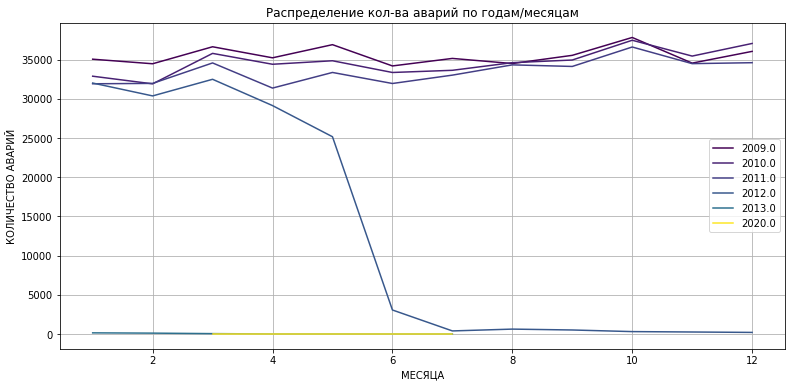

In [ ]:
fig, ax = plt.subplots(figsize=(13, 6))

ax = sns.lineplot(data = df, x = 'month', y = 'count',
                  hue = 'year', palette = 'viridis')

ax.set_ylabel('КОЛИЧЕСТВО АВАРИЙ')
ax.set_xlabel('МЕСЯЦА')

ax.set_title('Распределение кол-ва аварий по годам/месяцам')
ax.grid()
ax.legend()

plt.show()

Вывод:

- Все данные и необхоимые таблицы и столбцы присутсвуют в данных
Общий ключ, столбец- case_id
- Наибольший вслеск аварий, наблюдается в Марте, возможно виной этому погодные условия, в зимние месяцы, процент аварий, также довольно высок, по другим годам, мы видим похожую картину, хотя по некоторым годам также наблюдается и всплеск аварий в Октябре.
- Однако данные представлены только за 2009 - 2012 год, по этому мы с уверенностью можем говорить только про этот период. За 2020 год и за 2013 данные представлены не за весь период, а за другие года отсутствуют, что затрудняет анализ


**Дополнительный анализ гипотез**

Проанализируем, есть ли связь между типом кузова- VEHICLE_TYPE (таблица- Vehicles) и серьезностью повреждений - COLLISION_DAMAGE (таблица- collisions). Потенциально, это может означать что определенные типы кузовов, подтвержены более серьезному риску, чем другие машины

In [ ]:
query = '''
SELECT VEHICLE_TYPE,
       COLLISION_DAMAGE,
       COUNT(COLLISION_DAMAGE)
FROM collisions as c
JOIN vehicles as v on v.CASE_ID = c.CASE_ID
GROUP BY VEHICLE_TYPE, COLLISION_DAMAGE;
'''

df = sql_query(query)
df

,vehicle_type,collision_damage,count
0,coupe,fatal,8916
1,coupe,middle damage,131486
2,coupe,scratch,278571
3,coupe,severe damage,23807
4,hatchback,fatal,2786
5,hatchback,middle damage,17576
6,hatchback,scratch,19355
7,hatchback,severe damage,5878
8,minivan,fatal,527
9,minivan,middle damage,22046


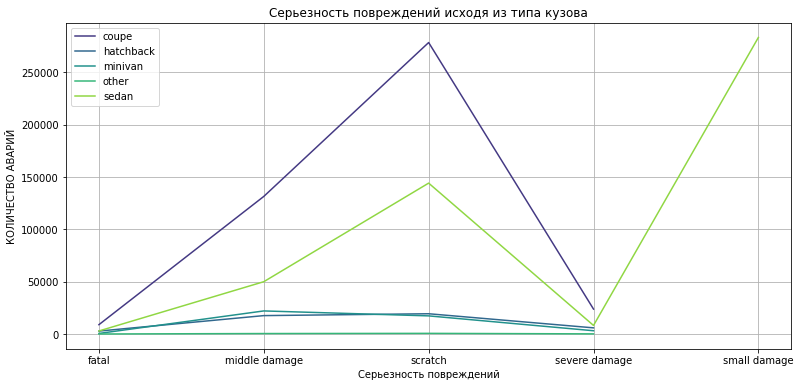

In [ ]:
fig, ax = plt.subplots(figsize=(13, 6))

ax = sns.lineplot(data = df, x = 'collision_damage', y = 'count',
                  hue = 'vehicle_type', palette = 'viridis')

ax.set_ylabel('КОЛИЧЕСТВО АВАРИЙ')
ax.set_xlabel('Серьезность повреждений')

ax.set_title('Серьезность повреждений исходя из типа кузова')
ax.grid()
ax.legend()

plt.show()

Вывод:
- Наиболее часто ДТП происходят для машин с типом кузова- Седан и Купе
- При этом тип кузова купе чаще подвержен более серьезным ДТП (fatal, severe и middle), нежели седан, хотя и минимальный тип повреждений- scratch также чаще всего получают именно авто, типа- седан

6. Проанализируйте, есть ли связь между возрастом автомобиля- VEHICLE_AGE(таблица- Vehicles) и нерабочим состоянием устройства управления - control_device (таблица- collisions), нам понадобятся только те данные, где указано, что устройство упралвения не функционирует (control_device = 'not functioning')

Алогоритм:
*   Сформируйте SQL запрос, через связь таблиц collisions и Vehicles по полю CASE_ID
*  Постройте график по результатам запроса
*  Сделайте вывод

Проанализируем, есть ли связь между возрастом автомобиля- VEHICLE_AGE(таблица- Vehicles) и нерабочим состоянием устройства управления - control_device (таблица- collisions), нам понадобятся только те данные, где указано, что устройство упралвения не функционирует (control_device = 'not functioning'). Гипотеза состоит в том, что возрас авто, может напрямую влиять на проблему неисправности авто и если это дейтвительно так, анализ поможет дополнительно это првоерить.


<AxesSubplot:xlabel='vehicle_age', ylabel='count'>

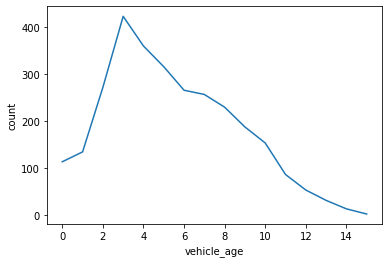

In [ ]:
query = '''
SELECT VEHICLE_AGE,
       COUNT(control_device)
FROM collisions as c
JOIN vehicles as v on v.CASE_ID = c.CASE_ID
WHERE control_device = 'not functioning'
GROUP BY VEHICLE_AGE, control_device;
'''

df = sql_query(query)
df

sns.lineplot(data=df, x="vehicle_age", y="count")

Вывод:
- Наиболее часто проблемы с устройством управления, испытывают автомобили возрастом- 3 года
- Далее, чем страше машина, тем менее она подвержена проблемам с устройсвом управления

# **Шаг 4. Создание модели для оценки водительского риска**

Подготовим данные, на основе гипотезы заказчика

- Выберите тип виновника — только машина (car).

- Возьмите случаи, когда ДТП привело к любым значимым повреждениям автомобиля любого из участников — все, кроме типа SCRATCH (царапина).

- Для моделирования возьмите данные только за 2012 год.

- Подготовка исходной таблицы должна проводиться с помощью sql-запроса.

- Проведите первичный отбор факторов, необходимых для модели.


In [ ]:
query = '''
SELECT *
FROM collisions as c
JOIN parties AS p ON c.case_id = p.case_id
JOIN vehicles AS v ON v.case_id = p.case_id
WHERE PARTY_TYPE = 'car'
  AND COLLISION_DAMAGE != 'scratch'
  AND EXTRACT(YEAR FROM collision_date) = 2012;
'''

df = sql_query(query)

In [ ]:
#Выведем на экран первые 5 строк датасета
df.head(5)


,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,5448788,0900,el dorado,200.0,north,0.0,clear,None,small damage,2,unknown,unknown,sideswipe,other motor vehicle,dry,normal,daylight,functioning,2012-01-15,16:15:00,2395289,5448788,1,car,0,25.0,had not been drinking,None,0.0,1320256,5448788,1,sedan,manual,4.0
1,5403341,1900,los angeles,1079.0,north,0.0,clear,None,fatal,2,vehicle code violation,improper passing,broadside,other motor vehicle,dry,normal,daylight,none,2012-01-01,10:40:00,2313089,5403341,2,car,0,53.0,had not been drinking,None,0.0,1275428,5403341,2,sedan,manual,3.0
2,5403341,1900,los angeles,1079.0,north,0.0,clear,None,fatal,2,vehicle code violation,improper passing,broadside,other motor vehicle,dry,normal,daylight,none,2012-01-01,10:40:00,2313089,5403341,2,car,0,53.0,had not been drinking,None,0.0,1275427,5403341,1,coupe,manual,5.0
3,5459631,5400,tulare,2112.0,west,0.0,cloudy,None,middle damage,2,vehicle code violation,speeding,rear end,other motor vehicle,wet,normal,daylight,none,2012-02-07,15:00:00,2415244,5459631,2,car,0,67.0,had not been drinking,None,0.0,1330992,5459631,2,coupe,auto,10.0
4,5459631,5400,tulare,2112.0,west,0.0,cloudy,None,middle damage,2,vehicle code violation,speeding,rear end,other motor vehicle,wet,normal,daylight,none,2012-02-07,15:00:00,2415244,5459631,2,car,0,67.0,had not been drinking,None,0.0,1330991,5459631,1,sedan,auto,5.0


In [ ]:
#Изучим колличество данных в каждом столбце датафрейма и типы данных в признаках
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118411 entries, 0 to 118410
Data columns (total 35 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   case_id                      118411 non-null  object 
 1   county_city_location         118411 non-null  object 
 2   county_location              118411 non-null  object 
 3   distance                     118411 non-null  float64
 4   direction                    89466 non-null   object 
 5   intersection                 118043 non-null  float64
 6   weather_1                    118022 non-null  object 
 7   location_type                55137 non-null   object 
 8   collision_damage             118411 non-null  object 
 9   party_count                  118411 non-null  int64  
 10  primary_collision_factor     118147 non-null  object 
 11  pcf_violation_category       116686 non-null  object 
 12  type_of_collision            117771 non-null  object 
 13 

In [ ]:
# Проанализируем колличество дубликатов в датасете
df.duplicated().sum()

0

In [ ]:
#И сразу их удалим
df.drop_duplicates(inplace= True)

In [ ]:
#А также, изучим более подробно числовые переменные
df.describe()

,distance,intersection,party_count,id,party_number,at_fault,insurance_premium,cellphone_in_use,id,party_number,vehicle_age
count,1.184110e+05,118043.000000,118411.000000,1.184110e+05,118411.000000,118411.000000,113289.000000,107507.000000,1.184110e+05,118411.000000,115046.000000
mean,7.320663e+02,0.234711,2.356487,2.594288e+06,1.647355,0.469686,38.624686,0.021320,1.429057e+06,1.681339,4.908263
std,6.902704e+03,0.423820,0.950973,9.899955e+04,0.812170,0.499082,16.355164,0.144448,5.452668e+04,0.784622,3.266265
min,0.000000e+00,0.000000,1.000000,1.800806e+06,1.000000,0.000000,0.000000,0.000000,9.855270e+05,1.000000,0.000000
25%,2.000000e+00,0.000000,2.000000,2.516794e+06,1.000000,0.000000,25.000000,0.000000,1.386167e+06,1.000000,3.000000
50%,1.180000e+02,0.000000,2.000000,2.597153e+06,1.000000,0.000000,36.000000,0.000000,1.431113e+06,2.000000,4.000000
75%,5.280000e+02,0.000000,3.000000,2.681314e+06,2.000000,1.000000,50.000000,0.000000,1.476229e+06,2.000000,7.000000
max,1.584000e+06,1.000000,10.000000,2.752388e+06,10.000000,1.000000,105.000000,1.000000,1.517654e+06,9.000000,161.000000


Вывод:
   - В данных присутствовало 377 дубликатов, которые мы сразу удалилили, так как они точно нам не понадобятся и могут исказить итоговую картину
   - Столбцы id и case_id задублились несколько раз в выгрузке и точно не пригодятся нам в итогом датафрейме, для обучения модели МЛ
   - В переменных есть ряд пропусков, но их природа нам не ясна, лучше будет выделить их как отдельный признак и заполнить пропуски в тех признаках, которые мы будем ичпользовать для обучения модели в дальнейшем
   - В колличесвтенных переменных- party_count, insurance_premium, vehicle_age и distance также присутсвутют выбросы, их природа нам пока не ясна, как и то, будем ли мы использовать все из этих признаков для обучения модели

interval columns not set, guessing: ['intersection', 'cellphone_in_use', 'at_fault']


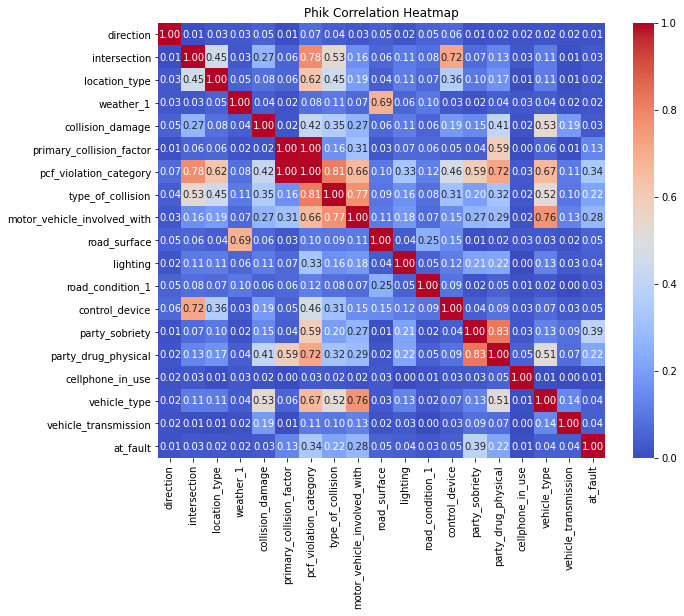

In [ ]:
var_cat = ['direction', 'intersection', 'location_type', 'weather_1',
           'collision_damage', 'primary_collision_factor', 'pcf_violation_category',
           'type_of_collision', 'motor_vehicle_involved_with',  'road_surface', 'lighting', 'road_condition_1', 'control_device',
           'party_sobriety', 'party_drug_physical', 'cellphone_in_use', 'vehicle_type', 'vehicle_transmission', 'at_fault']

phik_corr_matrix = phik_matrix(df[var_cat])

plt.figure(figsize=(10, 8))
sns.heatmap(phik_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Phik Correlation Heatmap")
plt.show()

('distance', 'party_count', 'id', 'party_number', 'insurance_premium')

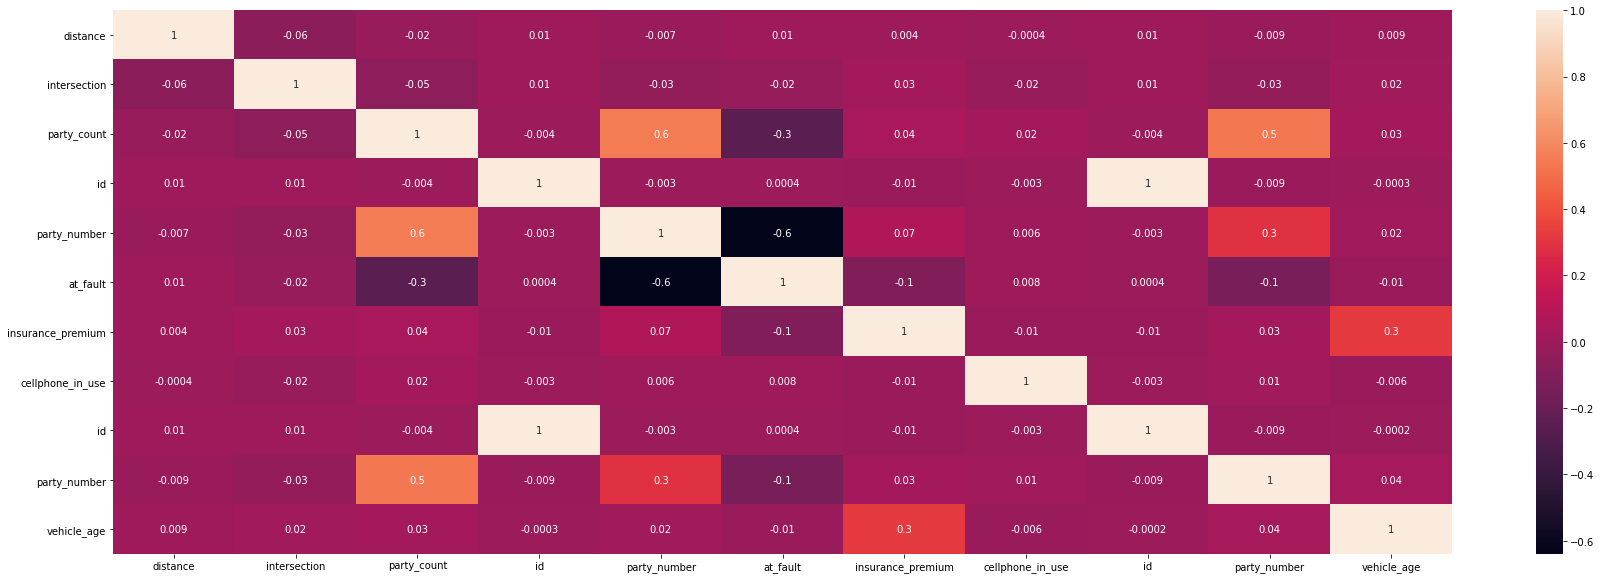

In [ ]:
fig, ax = plt.subplots(figsize=(30, 10))
sns.heatmap(df.corr(), annot = True, fmt='.1g')
'distance', 'party_count', 'id', 'party_number', 'insurance_premium'

Яная корреляция (0.1 и выше), с целевой переменной, была установлена, только для следующих признаков:
- party_number -0.1 Номер участника происшествия (не подходит, так как нельзя предсказать заранее, до начала поездки)
- INSURANCE_PREMIUM - 0.1
- party_drug_physical - 0.22
- party_sobriety - 0.39
- motor_vehicle_involved_with -  0.28
- type_of_collision - 0.22
- pcf_violation_category - 0.39
- primary_collision_factor - 0.13

Вывод- INSURANCE_PREMIUM, party_drug_physical, party_sobriety, type_of_collision, pcf_violation_category, primary_collision_factor обязательно стоит включить в датасет для обучени модели- new_df, с остальными признаками, корреляция, пока не прослеживается

Проведем первичный отбор факторов, которые способны повлиять на качество работы модели, как на основе логики, так и анализа матрицы корреляции выше

- weather_1 - погодные условия, также могут влиять на вероятность аварии
- location_type - влияет на сложность как маршрута, так и самой дороги
- pcf_violation_category- может помочь заранее предвосхитить некоторые риски, в зависимости от выбранного маршрута
- primary_collision_factor- может заранее помочь предвосхитить некоторые ошибки водителей
- motor_vehicle_involved_with- в определенных условиях, часть факторов может преобладать, что будет полезно сообщить водителю
- distance - растояние от главной дороги, может озанчать также более низкое качество дорог или же опасные участки, которые могут влиять на сложность маршрута
- road_surface - влияет на вероятность происшествия и может быть связано с другими факторами
- road_condition_1 - состояние дороги крайне важно при вождении
- lighting- может ухудшать видимость и быть причиной аравии   
- collision_date- оставить только месяц
- collision_time- разделить на утро, день, вечер, ночь
- party_sobriety- однозначно стоит проверять, возможно встроенным алкотестером
- party_drug_physical- может влиять на вероятность происшествия
- cellphone_in_use- можно будет также проверять
- vehicle_type- некоторые категории могут быть сложнее в упарвление, чем другие
- vehicle_transmission- может влиять на сложность управления
- vehicle_age- может влиять на вероятность происшествия
- INSURANCE_PREMIUM - Имеет высокую корреляцию с целевой переменной по Пирсону
---
- at_fault - целевая переменная



Создадим новый датасет с отобранными ранее признаками, для последующего обучения модели

In [ ]:
new_df = df[['weather_1',
             'location_type',
             'pcf_violation_category',
             'primary_collision_factor',
             'motor_vehicle_involved_with',
             'distance',
             'road_surface',
             'road_condition_1',
             'lighting',
             'collision_date',
             'collision_time',
             'party_sobriety',
             'party_drug_physical',
             'cellphone_in_use',
             'vehicle_type',
             'vehicle_transmission',
             'vehicle_age',
             'insurance_premium',
             'at_fault']]
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118411 entries, 0 to 118410
Data columns (total 19 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   weather_1                    118022 non-null  object 
 1   location_type                55137 non-null   object 
 2   pcf_violation_category       116686 non-null  object 
 3   primary_collision_factor     118147 non-null  object 
 4   motor_vehicle_involved_with  118079 non-null  object 
 5   distance                     118411 non-null  float64
 6   road_surface                 117645 non-null  object 
 7   road_condition_1             117843 non-null  object 
 8   lighting                     118080 non-null  object 
 9   collision_date               118411 non-null  object 
 10  collision_time               118283 non-null  object 
 11  party_sobriety               116682 non-null  object 
 12  party_drug_physical          8695 non-null    object 
 13 

# **Шаг 5. Проведем статистический анализ данных**

Проведем аналитику категориальных и числовых переменных, отобранных ранее, для последующей предобработки

In [ ]:
#Категориальные переменные
#county_location, county_city_location, direction, intersection, location_type, weather_1, collision_damage, primary_collision_factor, pcf_violation_category, type_of_collision, motor_vehicle_involved_with, road_surface, road_condition_1, lighting, control_device, party_type, party_sobriety, party_drug_physical, cellphone_in_use, vehicle_type, vehicle_transmission
#Числовые переменные
#distance, party_number, insurance_premium, vehicle_age

In [ ]:
new_df.describe()

,distance,cellphone_in_use,vehicle_age,insurance_premium,at_fault
count,1.184110e+05,107507.000000,115046.000000,113289.000000,118411.000000
mean,7.320663e+02,0.021320,4.908263,38.624686,0.469686
std,6.902704e+03,0.144448,3.266265,16.355164,0.499082
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,2.000000e+00,0.000000,3.000000,25.000000,0.000000
50%,1.180000e+02,0.000000,4.000000,36.000000,0.000000
75%,5.280000e+02,0.000000,7.000000,50.000000,1.000000
max,1.584000e+06,1.000000,161.000000,105.000000,1.000000


In [ ]:
pd.DataFrame(round(new_df.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
weather_1,0.000000
location_type,53.000000
pcf_violation_category,1.000000
primary_collision_factor,0.000000
motor_vehicle_involved_with,0.000000
distance,0.000000
road_surface,1.000000
road_condition_1,0.000000
lighting,0.000000
collision_date,0.000000


In [ ]:
# Создадим небольшую функцию для анализа данных в столбцах с числовыми значениями
def draw_distribution(df, x, x_label, y_label, title, bins):
    plt.figure(figsize=(12, 8))
    sns.histplot(data=df, x=x, kde=True, bins=bins)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

    plt.figure(figsize=(12, 8))
    sns.boxplot(data=df, x=x)
    plt.title(title)
    plt.xlabel(x_label)
    plt.show()

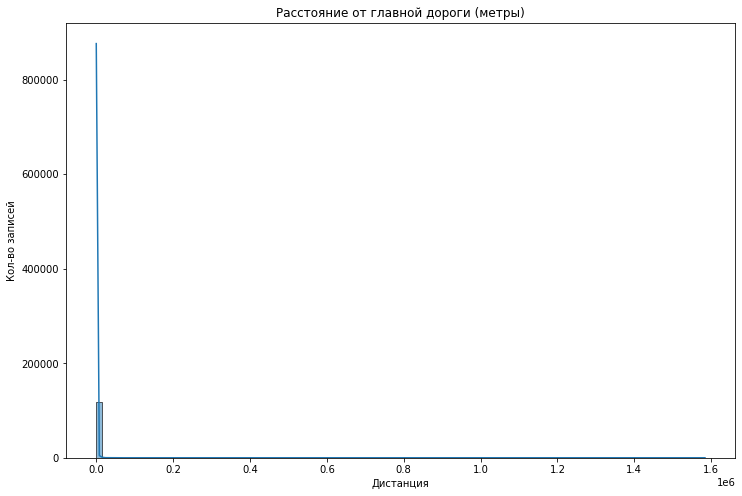

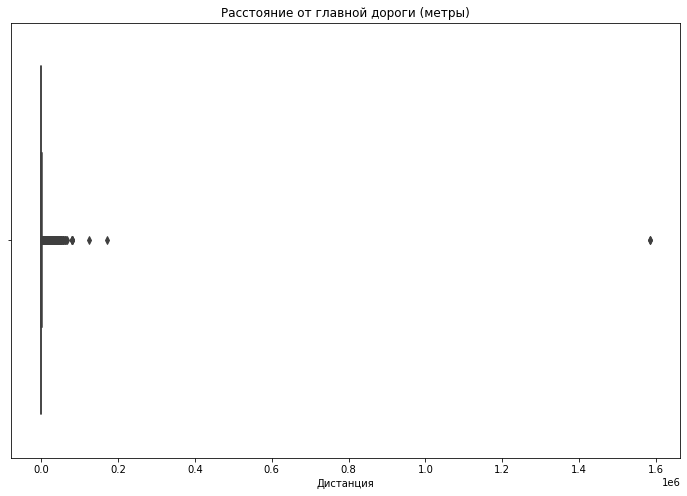

In [ ]:
draw_distribution(new_df, 'distance', 'Дистанция', 'Кол-во записей', 'Расстояние от главной дороги (метры)', 100)

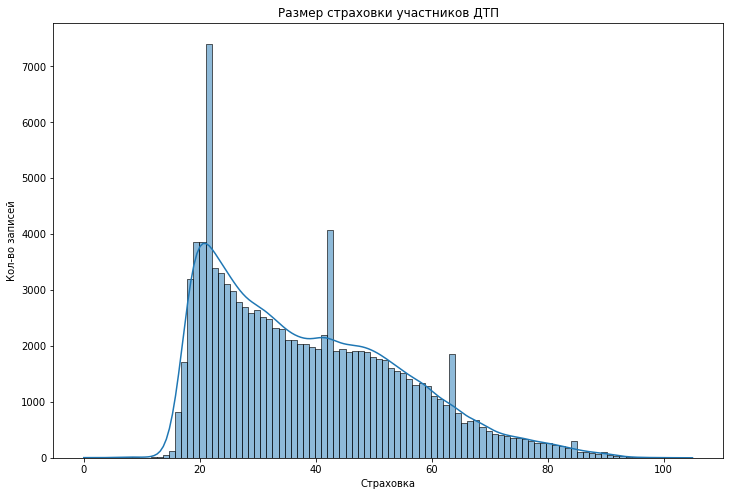

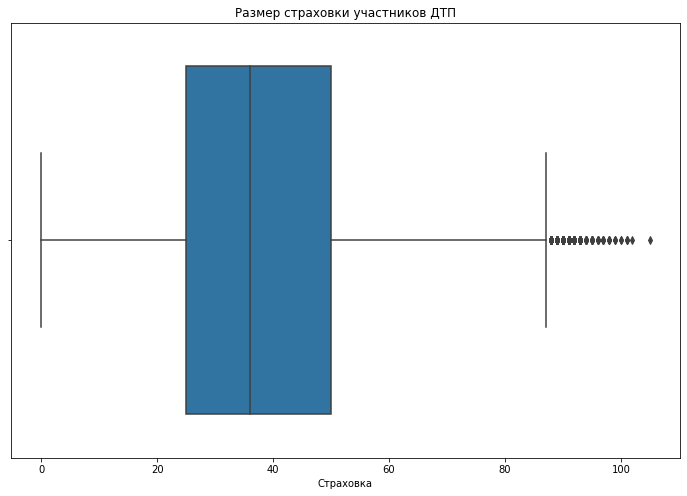

In [ ]:
draw_distribution(new_df, 'insurance_premium', 'Страховка', 'Кол-во записей', 'Размер страховки участников ДТП', 100)

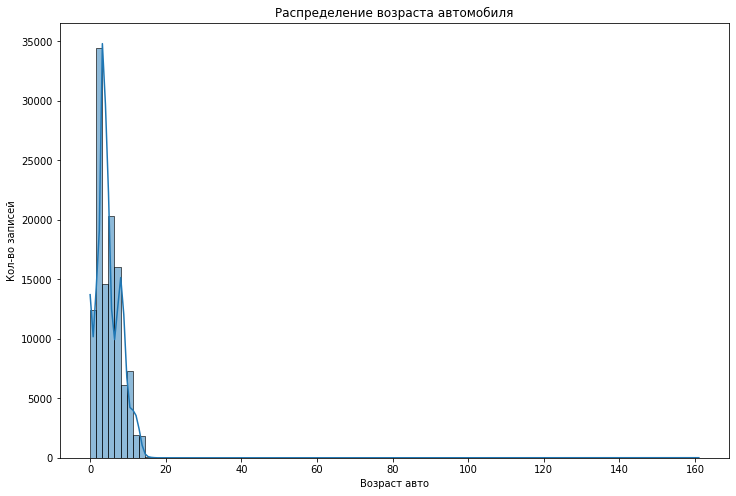

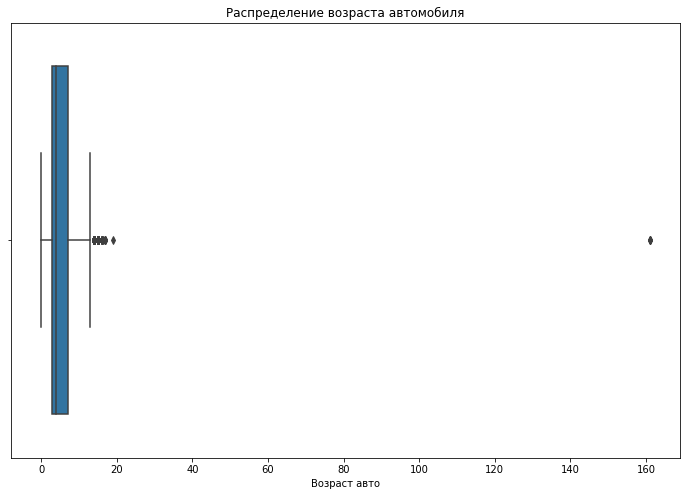

In [ ]:
draw_distribution(new_df, 'vehicle_age', 'Возраст авто', 'Кол-во записей', 'Распределение возраста автомобиля', 100)

Проверим категориальные перменные на наличие неявных дубликатов:

Ктегориальные переменные, соддержатся в столбцах:
county_location, county_city_location, direction, intersection, location_type, weather_1, collision_damage, primary_collision_factor, pcf_violation_category, type_of_collision, motor_vehicle_involved_with, road_surface, road_condition_1, lighting, control_device, party_type, party_sobriety, party_drug_physical, cellphone_in_use, vehicle_type, vehicle_transmission


In [ ]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118411 entries, 0 to 118410
Data columns (total 19 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   weather_1                    118022 non-null  object 
 1   location_type                55137 non-null   object 
 2   pcf_violation_category       116686 non-null  object 
 3   primary_collision_factor     118147 non-null  object 
 4   motor_vehicle_involved_with  118079 non-null  object 
 5   distance                     118411 non-null  float64
 6   road_surface                 117645 non-null  object 
 7   road_condition_1             117843 non-null  object 
 8   lighting                     118080 non-null  object 
 9   collision_date               118411 non-null  object 
 10  collision_time               118283 non-null  object 
 11  party_sobriety               116682 non-null  object 
 12  party_drug_physical          8695 non-null    object 
 13 

In [ ]:
#Изучим колличество дубликатов в новом датасете
new_df.duplicated().sum()

2171

In [ ]:
print('county_location', df['county_location'].unique())
print('county_city_location', df['county_city_location'].unique())
print('direction', df['direction'].unique())
print('intersection', df['intersection'].unique())
print('location_type', df['location_type'].unique())
print('weather_1', df['weather_1'].unique())
print('collision_damage', df['collision_damage'].unique())
print('primary_collision_factor', df['primary_collision_factor'].unique())
print('pcf_violation_category', df['pcf_violation_category'].unique())
print('type_of_collision', df['type_of_collision'].unique())
print('motor_vehicle_involved_with', df['motor_vehicle_involved_with'].unique())
print('road_surface', df['road_surface'].unique())
print('lighting', df['lighting'].unique())
print('road_condition_1', df['road_condition_1'].unique())
print('control_device', df['control_device'].unique())
print('party_type', df['party_type'].unique())
print('party_sobriety', df['party_sobriety'].unique())
print('party_drug_physical', df['party_drug_physical'].unique())
print('cellphone_in_use', df['cellphone_in_use'].unique())
print('vehicle_type', df['vehicle_type'].unique())
print('vehicle_transmission', df['vehicle_transmission'].unique())


county_location ['el dorado' 'los angeles' 'tulare' 'santa clara' 'contra costa'
 'san bernardino' 'fresno' 'humboldt' 'alameda' 'sacramento' 'orange'
 'sonoma' 'nevada' 'marin' 'riverside' 'monterey' 'san diego' 'kern'
 'tehama' 'san francisco' 'santa cruz' 'placer' 'ventura' 'solano' 'yuba'
 'san luis obispo' 'napa' 'madera' 'san mateo' 'santa barbara'
 'stanislaus' 'plumas' 'colusa' 'calaveras' 'san joaquin' 'yolo' 'sutter'
 'amador' 'tuolumne' 'butte' 'merced' 'san benito' 'lake' 'mendocino'
 'kings' 'siskiyou' 'lassen' 'inyo' 'mariposa' 'imperial' 'shasta' 'glenn'
 'mono' 'del norte' 'alpine' 'modoc' 'sierra' 'trinity']
county_city_location ['0900' '1900' '5400' '1992' '4300' '0700' '1942' '1965' '4313' '3604'
 '1005' '1203' '0109' '3400' '3019' '4905' '2900' '2100' '1955' '3309'
 '1902' '2700' '3001' '1975' '1963' '3711' '3619' '4980' '2708' '3004'
 '1500' '5202' '3801' '0791' '3709' '1976' '3300' '4402' '3630' '1931'
 '0100' '3105' '5604' '3600' '1915' '3022' '3040' '3029' '3100

Выводы:
- Неявных дубликатов в данных не обнаружено
- Есть выбросы в столбцах vehicle_age и distance, в vehicle_age их дейтвительно не много и их можно удалить без ущерба для датасета, тем более, что поскольку данные предоставлены за 2012, машины возрастом свыше 40 лет, кажутся довольно редкими, однако в столбце distance, выбросов слишком много и их природа нам не ясна, поэтому оставим их без изменений, чтобы не потерять данные
- Есть большое колличество пропусков в столбцах: location_type и party_drug_physical (более 50%), столбец location_type, можно будет заменить на столбец- intersection, так как они отчасти дублируют друг друга, но столбец intersection, содержит значительно меньше пропусков, а столбец party_drug_physical необходимо будет оставить, так как он показал довольно высокую корреялцию с целевым признаком

# **Шаг 6. Проведем предобработку данных и создание новых признаков, на основе отобранных данных**

In [ ]:
# Разделим време аварии на 4 временных зоны: утро, день, вечер и ночь, чтобы алгоритму было легче найти в данных взаимосвязи

new_df['collision_time'] = pd.to_datetime(
    new_df['collision_time'], format='%H:%M:%S'
)
new_df['collision_time'] = pd.DatetimeIndex(new_df['collision_time']).hour

def categorize_time(row):

    time = row['collision_time']

    if 6 <= time <= 11:
        return 'Morning'

    elif 12 <= time <= 16:
        return 'Day'

    elif 17 <= time <= 23:
        return 'Evening'

    elif 0 <= time <= 5:
        return 'Night'

new_df['collision_time'] = new_df.apply(categorize_time, axis=1)
new_df['collision_time']



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0             Day
1         Morning
2         Morning
3             Day
4             Day
           ...   
118406    Morning
118407        Day
118408        Day
118409        Day
118410        Day
Name: collision_time, Length: 118411, dtype: object

In [ ]:
# Выделим из даты аварии только месяц, день мало что сможет нам сказать, а год мы выбрали только 2012
new_df['collision_date'] = new_df['collision_date'] = pd.to_datetime(
    new_df['collision_date'], format='%Y-%m-%d'
)
new_df['collision_month'] = pd.DatetimeIndex(new_df['collision_date']).month
new_df['weekday'] = pd.DatetimeIndex(new_df['collision_date']).weekday

new_df = new_df.drop(['collision_date'], axis=1)
new_df['collision_month']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0         1
1         1
2         1
3         2
4         2
         ..
118406    1
118407    1
118408    1
118409    1
118410    1
Name: collision_month, Length: 118411, dtype: int64

In [ ]:
# Заменим столбец  с большим колличеством пропусков location_type на intersection с меньшим числом пропусков
new_df['location_type'] = df['intersection']

In [ ]:
#Удалим дубликаты
new_df.drop_duplicates(inplace= True)

In [ ]:
# Удаляем явные выбросы из датасета, выявленные на предыдущем этапе
data_no_outliers = new_df[(new_df['vehicle_age'] < 10)]
#data_no_outliers = data_no_outliers[(data_no_outliers['insurance_premium'] < 90)]

# Выводим исходные и обработанные данные
print("Исходные данные:")
print(new_df.info())
print("\nДанные без выбросов:")
print(data_no_outliers.info())

new_df = data_no_outliers

Исходные данные:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 116074 entries, 0 to 118410
Data columns (total 20 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   weather_1                    115695 non-null  object 
 1   location_type                115714 non-null  float64
 2   pcf_violation_category       114373 non-null  object 
 3   primary_collision_factor     115818 non-null  object 
 4   motor_vehicle_involved_with  115745 non-null  object 
 5   distance                     116074 non-null  float64
 6   road_surface                 115335 non-null  object 
 7   road_condition_1             115535 non-null  object 
 8   lighting                     115750 non-null  object 
 9   collision_time               115949 non-null  object 
 10  party_sobriety               114375 non-null  object 
 11  party_drug_physical          8582 non-null    object 
 12  cellphone_in_use             105379 non-n

In [ ]:
# Заполним пропуски в датасете, так как не все модели машинного обучения способны работать с пропусками  в данных
# Категориальные пропкуски заполним на unknown или 0 в случае с колличественными или категориальными переменными, указанными цифрами
new_df['pcf_violation_category'].fillna('unknown', inplace=True)
new_df['road_surface'].fillna('unknown', inplace=True)
new_df['road_condition_1'].fillna('unknown', inplace=True)
new_df['party_drug_physical'].fillna('unknown', inplace=True)
new_df['vehicle_age'].fillna(0, inplace=True)
new_df['insurance_premium'].fillna(0, inplace=True)
new_df['vehicle_transmission'].fillna('unknown', inplace=True)
new_df['party_sobriety'].fillna('unknown', inplace=True)
new_df['weather_1'].fillna('unknown', inplace=True)
new_df['primary_collision_factor'].fillna('unknown', inplace=True)
new_df['motor_vehicle_involved_with'].fillna('unknown', inplace=True)
new_df['collision_time'].fillna('unknown', inplace=True)
new_df['lighting'].fillna('unknown', inplace=True)


new_df['location_type'].fillna(-1, inplace=True)
new_df['cellphone_in_use'].fillna(-1, inplace=True)

new_df['location_type'] = new_df['location_type'].astype('str')
new_df['cellphone_in_use'] = new_df['cellphone_in_use'].astype('str')
new_df['collision_month'] = new_df['collision_month'].astype('str')
new_df['weekday'] = new_df['weekday'].astype('str')

Разделим датасет на 2 выборки и проведем масштабирование данных, а также
категоризируем их

In [ ]:
features = new_df.drop(['at_fault'], axis=1)
target = new_df['at_fault']

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=42, shuffle=True)

In [ ]:
# Проведем категоризацию категориальных и масштабирование признаков
var_categorical = ['party_drug_physical',
             'weather_1',
             'pcf_violation_category',
             'primary_collision_factor',
             'motor_vehicle_involved_with',
             'road_surface',
             'road_condition_1',
             'lighting',
             'collision_time',
             'party_sobriety',
             'vehicle_type',
             'vehicle_transmission',
             'weekday',
             'collision_month',
             'cellphone_in_use',
             'location_type']
var_numeric = ['vehicle_age', 'distance', 'insurance_premium']

encoder = OneHotEncoder(handle_unknown='ignore', drop='first')

features_train_ohe = pd.DataFrame(
        encoder.fit_transform(features_train[var_categorical]).toarray(),
        columns=encoder.get_feature_names_out()
)


features_valid_ohe = pd.DataFrame(
        encoder.transform(features_valid[var_categorical]).toarray(),
        columns=encoder.get_feature_names_out()
)


scaler = StandardScaler()

features_train_numeric= pd.DataFrame(
        scaler.fit_transform(features_train[var_numeric]),
        columns=var_numeric
   )

features_valid_numeric= pd.DataFrame(
        scaler.transform(features_valid[var_numeric]),
        columns=var_numeric
   )



features_train = features_train_numeric.join(features_train_ohe)
features_valid = features_valid_numeric.join(features_valid_ohe)

features_train

,vehicle_age,distance,insurance_premium,party_drug_physical_impairment - physical,party_drug_physical_not applicable,party_drug_physical_sleepy/fatigued,party_drug_physical_under drug influence,party_drug_physical_unknown,weather_1_cloudy,weather_1_fog,weather_1_other,weather_1_raining,weather_1_snowing,weather_1_unknown,weather_1_wind,pcf_violation_category_brakes,pcf_violation_category_dui,pcf_violation_category_fell asleep,pcf_violation_category_following too closely,pcf_violation_category_hazardous parking,pcf_violation_category_impeding traffic,pcf_violation_category_improper passing,pcf_violation_category_improper turning,pcf_violation_category_lights,pcf_violation_category_other equipment,pcf_violation_category_other hazardous violation,pcf_violation_category_other improper driving,pcf_violation_category_other than driver (or pedestrian),pcf_violation_category_pedestrian right of way,pcf_violation_category_pedestrian violation,pcf_violation_category_speeding,pcf_violation_category_traffic signals and signs,pcf_violation_category_unknown,pcf_violation_category_unsafe lane change,pcf_violation_category_unsafe starting or backing,pcf_violation_category_wrong side of road,primary_collision_factor_other improper driving,primary_collision_factor_other than driver,primary_collision_factor_unknown,primary_collision_factor_vehicle code violation,motor_vehicle_involved_with_bicycle,motor_vehicle_involved_with_fixed object,motor_vehicle_involved_with_motor vehicle on other roadway,motor_vehicle_involved_with_non-collision,motor_vehicle_involved_with_other motor vehicle,motor_vehicle_involved_with_other object,motor_vehicle_involved_with_parked motor vehicle,motor_vehicle_involved_with_train,motor_vehicle_involved_with_unknown,road_surface_slippery,road_surface_snowy,road_surface_unknown,road_surface_wet,road_condition_1_flooded,road_condition_1_holes,road_condition_1_loose material,road_condition_1_normal,road_condition_1_obstruction,road_condition_1_other,road_condition_1_reduced width,road_condition_1_unknown,lighting_dark with street lights,lighting_dark with street lights not functioning,lighting_daylight,lighting_dusk or dawn,lighting_unknown,collision_time_Evening,collision_time_Morning,collision_time_Night,collision_time_unknown,"party_sobriety_had been drinking, not under influence","party_sobriety_had been drinking, under influence",party_sobriety_had not been drinking,party_sobriety_impairment unknown,party_sobriety_not applicable,party_sobriety_unknown,vehicle_type_hatchback,vehicle_type_minivan,vehicle_type_other,vehicle_type_sedan,vehicle_transmission_manual,vehicle_transmission_unknown,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,collision_month_10,collision_month_11,collision_month_12,collision_month_2,collision_month_3,collision_month_4,collision_month_5,collision_month_6,collision_month_7,collision_month_8,collision_month_9,cellphone_in_use_0.0,cellphone_in_use_1.0,location_type_0.0,location_type_1.0
0,1.125108,0.162275,0.384481,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1.533005,-0.081063,0.144253,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,-0.098583,0.030150,0.624709,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0

# **Шаг 7. Построим модели и найдем наилучшую из них**

In [ ]:
#Изучим соотношение значений целевого признакана, для наиболее точного определения, необходимой нам метрики оценки качества модели.
new_df['at_fault'].value_counts()

0    53535
1    48256
Name: at_fault, dtype: int64

Так как классы целевой переменной находятся в условном балансе и ни один из них не преобладае над другим, в качесвте метрики классификации стоит выбрать метрику F1, так как случаи ложного срабатываения модели, когда предсказывать виновность водителя модель будет ошибочно, нам также нужно избежать

Проанализируем ряд моделей классификации, для подбора наилучшей из них

In [ ]:
#Модель KNeighborsClassifier

knn = KNeighborsClassifier()

knn_param_grid = {
    'n_neighbors': [3, 5, 7],  # Количество соседей
    'weights': ['uniform', 'distance'],  # Веса соседей
    'p': [1, 2],  # Параметр для метрики расстояния (1 для манхэттенского расстояния, 2 для евклидова)
}

knn_grid_search = GridSearchCV(knn, knn_param_grid, cv=5, scoring='f1')

knn_grid_search.fit(features_train, target_train)

print("KNeighborsClassifier- Лучшие параметры:", knn_grid_search.best_params_)
print("KNeighborsClassifier - Наилучшая оценка:", knn_grid_search.best_score_)

KNeighborsClassifier- Лучшие параметры: {'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}
KNeighborsClassifier - Наилучшая оценка: 0.5809569845425401


In [ ]:
#Модель DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier(random_state=0)
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
dt_grid_search = GridSearchCV(estimator=dt_classifier, param_grid=dt_param_grid, cv=5, scoring='f1')
dt_grid_search.fit(features_train, target_train)

# Выведите наилучшие параметры и оценку каждой модели
print("DecisionTreeClassifier - Лучшие параметры:", dt_grid_search.best_params_)
print("DecisionTreeClassifier - Наилучшая оценка:", dt_grid_search.best_score_)

DecisionTreeClassifier - Лучшие параметры: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
DecisionTreeClassifier - Наилучшая оценка: 0.6384188530441455


In [ ]:
# Модель CatBoostClassifier
catboost_classifier = CatBoostClassifier(random_state=0, silent= True)
catboost_param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 1],
    'iterations': [100, 500, 1000]
}
catboost_grid_search = GridSearchCV(estimator=catboost_classifier, param_grid=catboost_param_grid, cv=5, scoring='f1')
catboost_grid_search.fit(features_train, target_train)

print("CatBoostClassifier - Лучшие параметры:", catboost_grid_search.best_params_)
print("CatBoostClassifier - Наилучшая оценка:", catboost_grid_search.best_score_)

CatBoostClassifier - Лучшие параметры: {'depth': 6, 'iterations': 500, 'learning_rate': 0.1}
CatBoostClassifier - Наилучшая оценка: 0.6494617544122063


In [ ]:
DecisionTreeClassifier_result = dt_grid_search.best_params_, dt_grid_search.best_score_
CatBoostClassifier_result = catboost_grid_search.best_params_, catboost_grid_search.best_score_
KNeighborsClassifier_result = knn_grid_search.best_params_, knn_grid_search.best_score_

# Выведите наилучшие параметры и оценку каждой модели
print("DecisionTreeClassifier - Лучшие параметры:", dt_grid_search.best_params_)
print("DecisionTreeClassifier - Наилучшая оценка:", dt_grid_search.best_score_)
print("CatBoostClassifier - Лучшие параметры:", catboost_grid_search.best_params_)
print("CatBoostClassifier - Наилучшая оценка:", catboost_grid_search.best_score_)
print("KNeighborsClassifier - Лучшие параметры:", knn_grid_search.best_params_)
print("KNeighborsClassifier - Наилучшая оценка:", knn_grid_search.best_score_)

DecisionTreeClassifier - Лучшие параметры: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
DecisionTreeClassifier - Наилучшая оценка: 0.6384188530441455
CatBoostClassifier - Лучшие параметры: {'depth': 6, 'iterations': 500, 'learning_rate': 0.1}
CatBoostClassifier - Наилучшая оценка: 0.6494617544122063
KNeighborsClassifier - Лучшие параметры: {'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}
KNeighborsClassifier - Наилучшая оценка: 0.5809569845425401


На основе полученных данных, делаем таблицу для сравнения и выбора наилучшей модели

In [ ]:
display(pd.DataFrame([DecisionTreeClassifier_result, CatBoostClassifier_result, KNeighborsClassifier_result],
             columns=['Гиперпараметры', 'F1'],
                      index=['DecisionTreeClassifier','CatBoostClassifier', 'KNeighborsClassifier']))

,Гиперпараметры,F1
DecisionTreeClassifier,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.638419
CatBoostClassifier,"{'depth': 6, 'iterations': 500, 'learning_rate...",0.649462
KNeighborsClassifier,"{'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}",0.580957


# **Шаг 8. Анализ наилучшей модели и ее признаков**

Проверяем гиперпараметры наилучшей модели на валидационном датасете (для проверки адекватности ее работы)

In [ ]:
#DecisionTreeClassifier - Лучшие параметры: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
#DecisionTreeClassifier - Наилучшая оценка: 0.6610001944808026

In [ ]:
model = DecisionTreeClassifier(random_state=0, criterion='entropy', max_depth=None, min_samples_leaf=1, min_samples_split=2)
model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)
f1_score(target_valid, predictions_valid)

0.6452543910282841

Выведем на экран граифик матрицы ошибок в пайтон

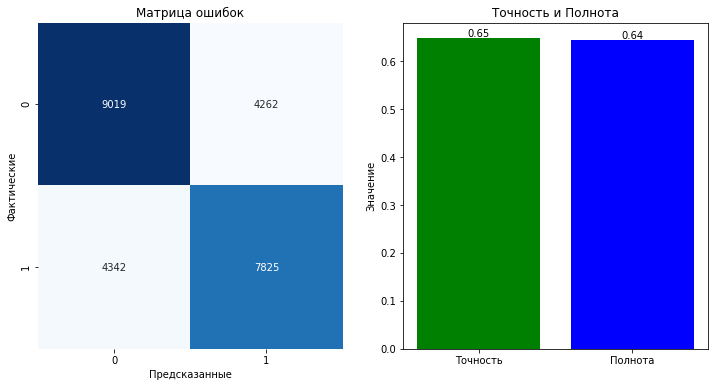

In [ ]:
# Рассчитать матрицу ошибок
cm = confusion_matrix(target_valid, predictions_valid)

# Рассчитать точность и полноту
precision = precision_score(target_valid, predictions_valid)
recall = recall_score(target_valid, predictions_valid)

# Создать фигуру с двумя подграфиками (графиками)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Первый подграфик: Матрица ошибок
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax1)
ax1.set_xlabel('Предсказанные')
ax1.set_ylabel('Фактические')
ax1.set_title('Матрица ошибок')

# Второй подграфик: Точность и полнота
ax2.bar(['Точность', 'Полнота'], [precision, recall], color=['green', 'blue'])
ax2.set_ylabel('Значение')
ax2.set_title('Точность и Полнота')

# Добавить подписи к столбцам на графике точности и полноты
for i, v in enumerate([precision, recall]):
  ax2.text(i, v, f'{v:.2f}', ha='center', va='bottom')

# Отобразить графики
plt.show()

Проанализируем важность основных факторов, влияющих на вероятность ДТП по результатам обучения Desision Tree

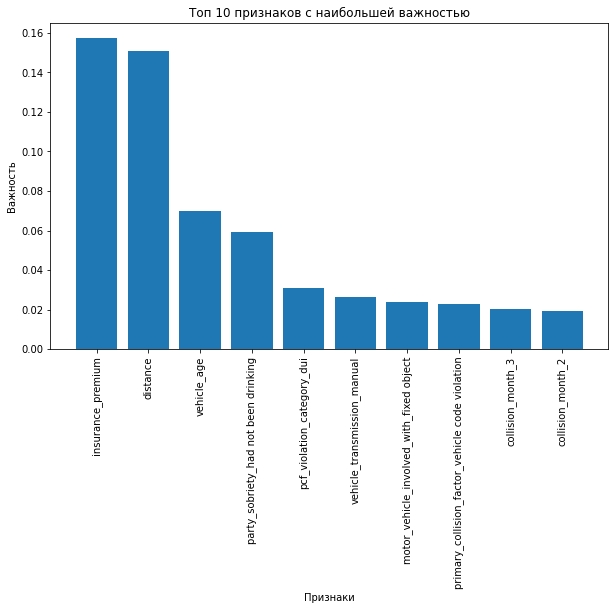

Признак: insurance_premium, Важность: 0.15723370678275367
Признак: distance, Важность: 0.15110109724114162
Признак: vehicle_age, Важность: 0.07011386000466739
Признак: party_sobriety_had not been drinking, Важность: 0.058995624342740235
Признак: pcf_violation_category_dui, Важность: 0.030918498798911686
Признак: vehicle_transmission_manual, Важность: 0.026370981807211716
Признак: motor_vehicle_involved_with_fixed object, Важность: 0.023805699362345834
Признак: primary_collision_factor_vehicle code violation, Важность: 0.022772923245841716
Признак: collision_month_3, Важность: 0.020254025446868586
Признак: collision_month_2, Важность: 0.01908727799473874


In [ ]:
# Получим важность признаков и выведем топ 10 из них на экран
importances = model.feature_importances_

feature_importances = list(zip(features_train.columns, importances))
feature_importances.sort(key=lambda x: x[1], reverse=True)

top_10_features = feature_importances[:10]

plt.figure(figsize=(10, 6))
plt.bar(range(len(top_10_features)), [x[1] for x in top_10_features], tick_label=[x[0] for x in top_10_features])
plt.xlabel('Признаки')
plt.ylabel('Важность')
plt.title('Топ 10 признаков с наибольшей важностью')
plt.xticks(rotation=90)
plt.show()

for feature, importance in top_10_features:
    print(f'Признак: {feature}, Важность: {importance}')

А теперь посмотрим внимательнее на связь этих признаков с целевой перемнной

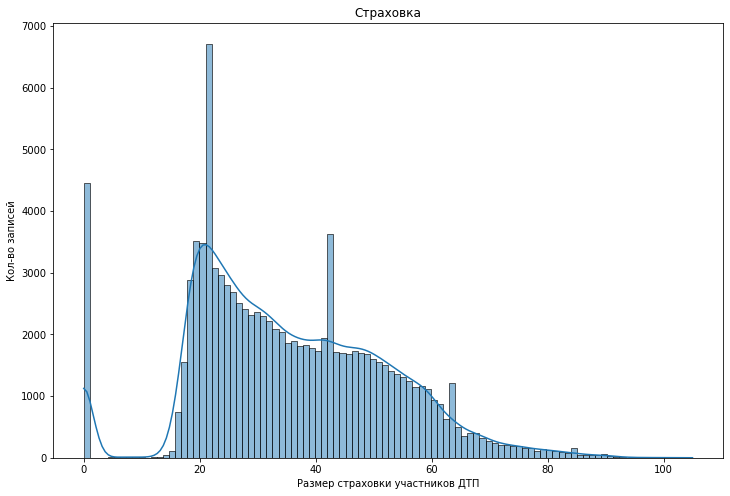

In [ ]:
    plt.figure(figsize=(12, 8))
    sns.histplot(data=new_df, x=new_df['insurance_premium'], kde=True, bins=100)
    plt.title('Страховка')
    plt.xlabel('Размер страховки участников ДТП')
    plt.ylabel('Кол-во записей')
    plt.show()

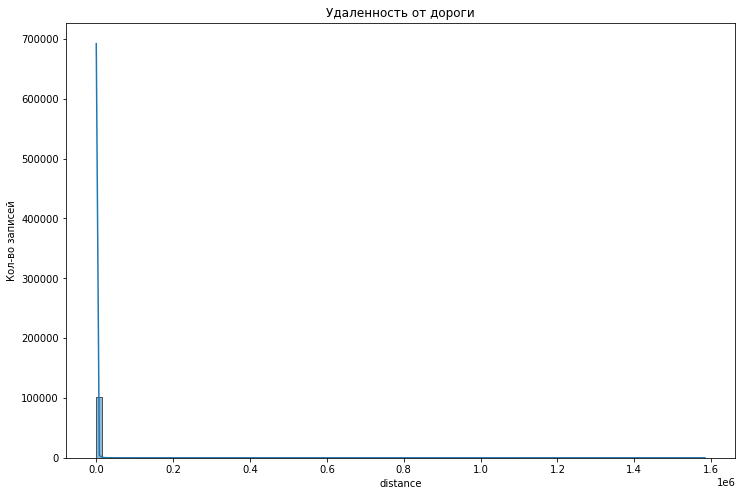

In [ ]:
    plt.figure(figsize=(12, 8))
    sns.histplot(data=new_df, x=new_df['distance'], kde=True, bins=100)
    plt.title('Удаленность от дороги')
    plt.ylabel('Кол-во записей')
    plt.show()

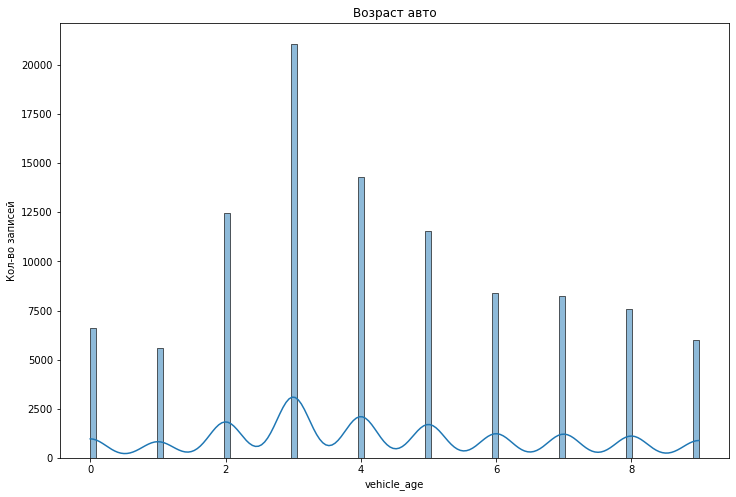

In [ ]:
    plt.figure(figsize=(12, 8))
    sns.histplot(data=new_df, x=new_df['vehicle_age'], kde=True, bins=100)
    plt.title('Возраст авто')
    plt.ylabel('Кол-во записей')
    plt.show()

Вывод по анализу наилучшей модели:
- Одним из важнейших факторов, в нашем случае, интересно, что чем выше страховка, тем меньше мы наблюдаем случае ДТП, возможно увеличение страхование, также поможет снизить число ДТП
- Вторым по кажности фактором для модели машинного обучения оказалась удаленность от главной дороги, и хотя вполне возможно, это связано с недостаточной реперезентативностью наших данных, однако возможность в данном факторе дейтвительно есть корреляция и удаленноть от главной дороги, дейтвительно влияет на предотвращение ДТП, в силу меньшего оживленности движения вдали от главных трас
- Также, довольно важным фактором аварий, можно выделить то, что довольно часто причиной аварии, становится нарушение ПДД водиетелем, одним из способов решить это, я вижу ввести некоторый ценз на опыт водителя и выдавать машины в аренду, только при условии, что водительским правам водителя минмум 2 года, да конечно это не гарантирует что этот водитель будет соблюядать правила, но может помочь сразу отсеить, неопытных водителей + также пассажирское кресло, можно снабдить дополнительной камерой, которая бы позволяла следить за тем, что за рулем находится именно владелец прав, чтобы избежать обмана системы
- Инетерсно наблюдать и то, что начиная с 5 летнего возраста авто, чем оно становится старше, чем меньше с ним происходит ДТП, так например чаще всего ДТП происходят с авто в возрасте от 2х до 5 лет, при этому более нвоые или старые авто, подвержены этому риску меньше
- Созданные нами новые признаки, судя по аналитике Shap не оказали существенного влияние на прирост качества модели

# **Шаг 9. Итоговый вывод**

- Наилучшую метрику f1 на тренировочном датасете показала модель- DecisionTreeClassifier с гиперпараметрами- {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
- Полученная метрика, показала что создание модели предсказывающей вероятность ДТП по вине водителя вполне возможна, однако для более точного обучения модели, нам необходимо больше признаков
- ТАк например, для более точного понимания возможности предотвращения или профилактики ДТП, нам нужно больше данных, например исходя из того что страховка, оказалась одним из важнейших факторов для модели, я считаю, что нужно преждве всего собрать больше информации о том, от чего зависит сумма страховки, возможно страховка зависит от марки автомобиля и именно это и является одним из важных факторов будущей аварии
- Также, одной из рекомендаций, можно считать применение дополнительных мер предосторожностей в марте, как месяцу с самым большим колличеством аварий за весь период
- Точность и полнота, также оказались на примерно равном уровне, что также может являться признаком хорошей модели